# Basic `TimeSeriesX` functionality

At its core, PTSA interacts with time series data via the `TimeSeriesX` class, a thin wrapper around `xarray`'s `DataArray`. In the following examples, you will learn the basics.

In [1]:
import numpy as np

# For plotting
%matplotlib inline
from matplotlib import pyplot as plt

# The class in question; also available in the less-Pythonic ptsa.data.TimeSeriesX module.
from ptsa.data.timeseries import TimeSeriesX

At a minimum, a time series must have a time dimension and a sample rate. Because of the internals of `xarray`, sample rates are stored as a scalar coordinate. We can either specify this as a coordinate when creating a new `TimeSeriesX` instance, or we can use the convenience `TimeSeriesX.create` class method.

To get started, let's take a simple case where we have only a single channel of data. We will generate a noisy sinuosoidal signal:

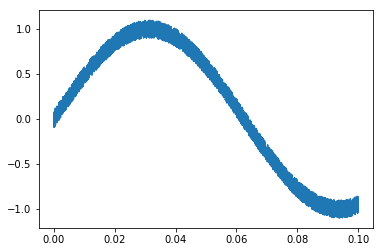

In [2]:
num_points = 5000  # number of points to generate
sample_rate = 10.  # the sample rate in Hz
frequency = 8.  # generated sine wave frequency in Hz

t = np.linspace(0, 1, num_points) / sample_rate
data = np.sin(2*np.pi*frequency*t) + np.random.uniform(-0.1, 0.1, num_points)
plt.plot(t, data)

Creating a time series object by explicitly passing the sample rate as a coordinate:

In [3]:
coords = {"time": t, "samplerate": sample_rate}
ts = TimeSeriesX(data, coords=coords, dims=['time'])
print(ts)

<xarray.TimeSeriesX (time: 5000)>
array([-0.064745, -0.018316,  0.075394, ..., -0.985951, -1.03767 , -0.878288])
Coordinates:
  * time        (time) float64 0.0 2e-05 4.001e-05 6.001e-05 8.002e-05 ...
    samplerate  float64 10.0


... or using `TimeSeriesX.create`:

In [4]:
coords = dict(time=t)
ts = TimeSeriesX.create(data, sample_rate, coords=coords, dims=['time'])
print(ts)

<xarray.TimeSeriesX (time: 5000)>
array([-0.064745, -0.018316,  0.075394, ..., -0.985951, -1.03767 , -0.878288])
Coordinates:
  * time        (time) float64 0.0 2e-05 4.001e-05 6.001e-05 8.002e-05 ...
    samplerate  float64 10.0


## Resampling

We often need to resample time series data when making comparisons between different data sets or to downsample data that has higher resolution than necessary. This can be done using the `TimeSeriesX.resampled` method:

<xarray.TimeSeriesX (time: 500)>
array([-0.442986,  0.08222 , -0.016573, ..., -0.968795, -0.906258, -1.053924])
Coordinates:
  * time        (time) float64 0.0 0.0002 0.0004001 0.0006001 0.0008002 ...
    samplerate  float64 1.0
Original number of data points: 5000
New number of data points: 500


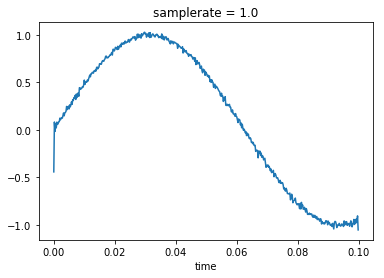

In [5]:
new_rate = 1.
resampled = ts.resampled(new_rate)
print(resampled)
print("Original number of data points:", len(ts.data))
print("New number of data points:", len(resampled.data))
resampled.plot()

## Saving and loading with HDF5

For convenience, we can save and load data in the HDF5 file format using the `TimeSeriesX.to_hdf` and `TimeSeriesX.from_hdf` methods.

In [6]:
resampled.to_hdf("resampled.h5")

<xarray.TimeSeriesX (time: 500)>
array([-0.442986,  0.08222 , -0.016573, ..., -0.968795, -0.906258, -1.053924])
Coordinates:
  * time        (time) float64 0.0 0.0002 0.0004001 0.0006001 0.0008002 ...
    samplerate  float64 1.0
<xarray.TimeSeriesX (time: 500)>
array([-0.442986,  0.08222 , -0.016573, ..., -0.968795, -0.906258, -1.053924])
Coordinates:
  * time        (time) float64 0.0 0.0002 0.0004001 0.0006001 0.0008002 ...
    samplerate  float64 1.0


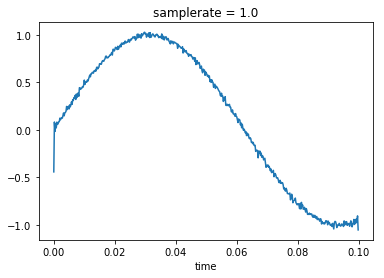

In [7]:
other_resampled = TimeSeriesX.from_hdf("resampled.h5")
print(resampled)
print(other_resampled)
other_resampled.plot()